In [1]:
from pscore_match.pscore import PropensityScore
from pscore_match.match import Match, whichMatched
from pscore_match.match import rank_test
from pscore_match.match import t_test
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Propensity Score Matching Analysis (pscore_match)

Participants with an aggregate score of 4 or 5 vascular risk factors (VRFs) were propensity scored matched on age and sex for those with a score of 0, using the pscore_match package for python [1].

In [2]:
data = pd.read_csv('casuality_data_final_factor_analyzer.csv')
data.shape

(2065, 1427)

In [3]:
S0 = data.loc[data['agg_score'] == 0]
S1 = data.loc[data['agg_score'] == 1]
S2 = data.loc[data['agg_score'] == 2]
S3 = data.loc[data['agg_score'] == 3]
S4 = data.loc[data['agg_score'] == 4]
S5 = data.loc[data['agg_score'] == 5]
S0.shape, S1.shape, S2.shape, S3.shape, S4.shape, S5.shape

((523, 1427), (606, 1427), (555, 1427), (273, 1427), (91, 1427), (17, 1427))

In [4]:
S_45 = pd.concat((S4, S5), axis=0)
S_45["agg_score"] = S_45["agg_score"].map({4:1, 5:1})
S_45.shape

(108, 1427)

In [5]:
data_new = pd.concat((S0, S_45), axis=0, ignore_index = True)
data_new.shape

(631, 1427)

In [6]:
test_obs = data_new.loc[data_new['agg_score'] == 1]
control_obs = data_new.loc[data_new['agg_score'] == 0]
test_obs.shape, control_obs.shape

((108, 1427), (523, 1427))

## 1. Distributions before matching

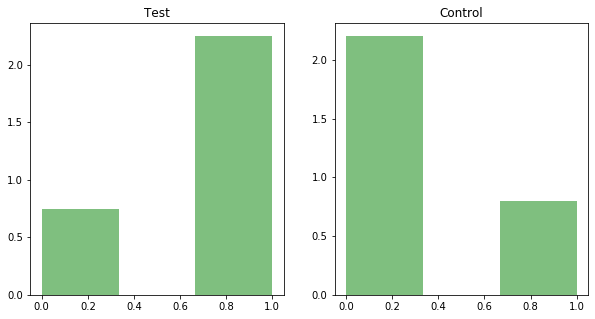

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Test', loc ='center')
n, bins, patches = plt.hist(test_obs["cardio_cov_sex"], 3, density=True, facecolor='g', alpha=0.5)

plt.subplot(1,2,2)
plt.title('Control', loc ='center')
n, bins, patches = plt.hist(control_obs["cardio_cov_sex"], 3, density=True, facecolor='g', alpha=0.5)
plt.show()

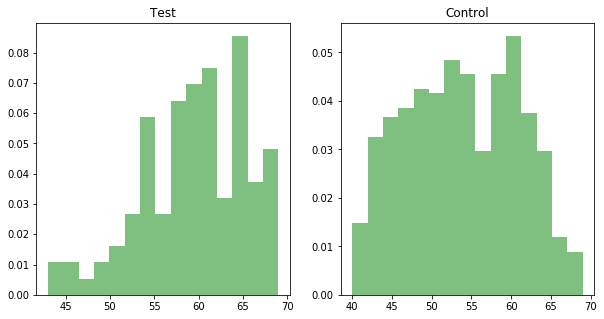

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Test', loc ='center')
n, bins, patches = plt.hist(test_obs["cardio_cov_age"], 15, density=True, facecolor='g', alpha=0.5)

plt.subplot(1,2,2)
plt.title('Control', loc ='center')
n, bins, patches = plt.hist(control_obs["cardio_cov_age"], 15, density=True, facecolor='g', alpha=0.5)
plt.show()

In [9]:
mean_test_sex = test_obs["cardio_cov_sex"].mean()
mean_test_age = test_obs["cardio_cov_age"].mean()
mean_control_sex = control_obs["cardio_cov_sex"].mean()
mean_control_age = control_obs["cardio_cov_age"].mean()

In [10]:
print(str("Test sex mean: " + str(mean_test_sex)))
print(str("Test age mean: " + str(mean_test_age)))
print(str("Control sex mean: " + str(mean_control_sex)))
print(str("Control age mean: " + str(mean_control_age)))

Test sex mean: 0.75
Test age mean: 59.583333333333336
Control sex mean: 0.26577437858508607
Control age mean: 53.79158699808795


## 2. Matching

In [11]:
# Covariates to test on
cov_list = ['cardio_cov_sex', 'cardio_cov_age']
covariates = data_new[cov_list]
treatment = data_new['agg_score']

Pscore module contains a class to estimate propensity scores for each observation. The compute method uses a generalized linear model to regress treatment on covariates to estimate the propensity score. This is not the only way to estimate the propensity score, but it is the most common. The two options allowed are logistic regression and probit regression.

In [12]:
pscore = PropensityScore(treatment, covariates).compute()

Match module implements several variants of matching: one-to-one matching, one-to-many matching, with or without a caliper, and without or without replacement.

In [13]:
pairs = Match(treatment, pscore)
pairs.create(method='one-to-one', replace=True)

C:\Users\Alejandro\Downloads\ANACONDA\lib\site-packages\pscore_match\match.py:135: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  matches[m] = dist.argmin()    # Potential problem: check for ties


In [14]:
# Simple function to convert output of Matches to DataFrame of all matched observations
data_matched = whichMatched(pairs, pd.DataFrame({'pscore': pscore, 'treatment' :treatment, 
                                                 'sex':covariates['cardio_cov_sex'],
                                                 'age':covariates['cardio_cov_age']}))

In [15]:
data_matched.head()

,pscore,treatment,sex,age
2,0.515691,0,1,63
2,0.515691,0,1,63
2,0.515691,0,1,63
3,0.257954,0,1,53
3,0.257954,0,1,53


Let’s see how the covariate imbalance improves after matching. If there is good covariate balance, the treatment and control group distributions of propensity scores should overlap. The gray smoothed density represents the treatment group and the black line represents controls. Before matching, there are a large number of controls with smaller probability of getting called; after matching, we have a group of controls whose propensity scores match those in the treatment group.

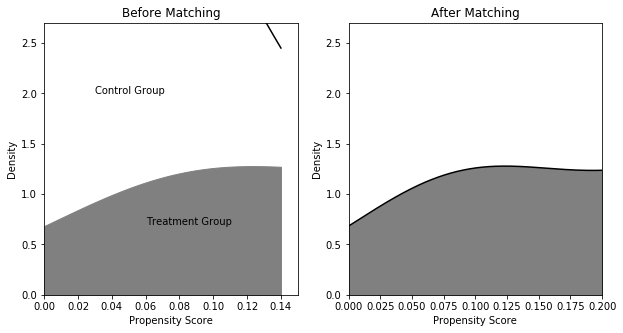

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
density0 = gaussian_kde(pscore[treatment==0])
density1 = gaussian_kde(pscore[treatment==1])
xs = np.linspace(0,0.14,200)
plt.plot(xs,density0(xs),color='black')
plt.fill_between(xs,density1(xs),color='gray')
plt.text(0.03, 2, 'Control Group')
plt.text(0.06, 0.7, 'Treatment Group')
plt.title('Before Matching')
plt.axis([0, 0.15, 0, 2.7])
plt.xlabel('Propensity Score')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
density0_post = gaussian_kde(data_matched.pscore[data_matched.treatment==0])
density1_post = gaussian_kde(data_matched.pscore[data_matched.treatment==1])
xs = np.linspace(0,0.2,200)
plt.plot(xs,density0_post(xs),color='black')
plt.fill_between(xs,density1_post(xs),color='gray')
plt.title('After Matching')
plt.axis([0, 0.2, 0, 2.7])
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.show()

### Covariace Balance test

By definition, propensity score matching helps improve the overlap of the treatment and control group propensity score distributions. But does our estimated propensity score help improve the overlap of covariate distributions?

We can check this visually, the same way as we did with the propensity score distributions before and after matching, or we can look at many covariates at once by running statistical tests. For each covariate we want to balance, we can run a two-sample test to compare the distributions for the treatment and control groups. We do this before matching and again after matching, instead comparing the treatment group with the matched controls. We hope to see that the matched controls are similar to the treated group on all these covariates.

Important note: I don’t “believe” the p-values coming out of these tests, in the sense that the necessary assumptions are definitely violated. However, they can serve as a crude measure of how similar the treatment and control group distributions are. A “small” p-value suggests that they’re very different.

Ideally, we’d want to iterate this process of estimating propensity scores and testing covariate balance until we deem them to be sufficiently balanced.

We ran both a t-test and a Wilcoxon rank sum test for each covariate in the propensity score model.

In [17]:
# Plot the p-values for covariate balance before and after matching
import plotly
pairs.plot_balance(covariates, filename='ggi-balance', auto_open=False)

C:\Users\Alejandro\Downloads\ANACONDA\lib\site-packages\plotly\offline\offline.py:563: UserWarning:

Your filename `ggi-balance` didn't end with .html. Adding .html to the end of your file.



<center><img src="Figures/pscore matching.png"></center>

As we can see, covariate imbalance improved for everything, therefore the matching worked.

Wilcoxon rank sum test for the distribution of treatment and control covariates.

Returns a list of p-values, one for each column in covariates

In [18]:
rank_test(covariates, treatment)

array([2.21107348e-15, 1.47171170e-13])

Two sample t test for the distribution of treatment and control covariates. 

Returns a list of p-values, one for each column in covariates

In [19]:
t_test(covariates, treatment)

array([1.92101462e-23, 3.51396998e-14])

## 3. Distributions after matching

In [20]:
test_match = data_matched.loc[data_matched['treatment'] == 1]
control_match = data_matched.loc[data_matched['treatment'] == 0]
test_match.shape, control_match.shape

((108, 4), (108, 4))

In [21]:
test_match.index.nunique(), control_match.index.nunique()

(108, 39)

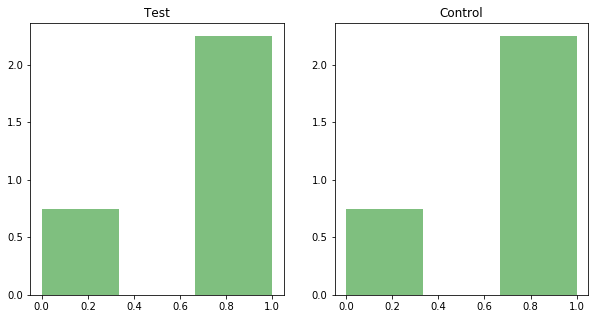

In [22]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Test', loc ='center')
n, bins, patches = plt.hist(test_match["sex"], 3, density=True, facecolor='g', alpha=0.5)

plt.subplot(1,2,2)
plt.title('Control', loc ='center')
n, bins, patches = plt.hist(control_match["sex"], 3, density=True, facecolor='g', alpha=0.5)
plt.show()

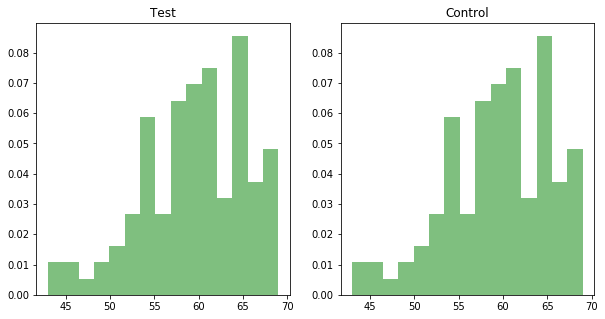

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Test', loc ='center')
n, bins, patches = plt.hist(test_match["age"], 15, density=True, facecolor='g', alpha=0.5)

plt.subplot(1,2,2)
plt.title('Control', loc ='center')
n, bins, patches = plt.hist(control_match["age"], 15, density=True, facecolor='g', alpha=0.5)
plt.show()

In [24]:
mean_test_sex = test_match["sex"].mean()
mean_test_age = test_match["age"].mean()
mean_control_sex = control_match["sex"].mean()
mean_control_age = control_match["age"].mean()

In [25]:
print(str("Test sex mean: " + str(mean_test_sex)))
print(str("Test age mean: " + str(mean_test_age)))
print(str("Control sex mean: " + str(mean_control_sex)))
print(str("Control age mean: " + str(mean_control_age)))

Test sex mean: 0.75
Test age mean: 59.583333333333336
Control sex mean: 0.75
Control age mean: 59.583333333333336


As we can see, we also plotted the mean distributions for age and sex before and after matching, and computed the means for these covariates for both our control and test groups. These results shows us how the matching procedure worked since these distributions are more balanced after applying propensity score matching. In addition, it is also noticeable that before matching, there are more males than females in the test group (patients with four and five VRFs). Furthermore, the age mean for the test group (59.58) before matching is much higher than the control’s group (53.79).

## 4. References

[1]: [Ottoboni, K. (2020)](http://www.kellieottoboni.com/pscore_match/index.html). pscore_match’s documentation